In [ ]:
!pip install scikeras
!pip install tensorflow
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    U

In [ ]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
from datetime import datetime
from google.colab import drive
import numpy as np

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Descriptiva

In [ ]:
file_path1 = '/content/gdrive/MyDrive/TFG/AAPL.csv'

file_path1_s = '/content/gdrive/MyDrive/TFG/Apple.csv' #Sentiment


apple = pd.read_csv(file_path1)
apple_s = pd.read_csv(file_path1_s)

apple = apple[['Date','Open', 'High', 'Low',  'Volume', 'Close']]


apple_s['Sentiment']=(apple_s['finupPartscr']-apple_s['findownPartscr'])/(apple_s['finupPartscr']+apple_s['findownPartscr'])
apple_s = pd.merge(apple, apple_s, on='Date', how='left', suffixes=('_apple', '_apple_s'))
apple_s = apple_s[['Date','Open', 'High', 'Low', 'Volume','Sentiment', 'Close']]

#apple.set_index('Date', inplace=True)
#apple_s.set_index('Date', inplace=True)


print(apple.head())
print(apple_s.head())

         Date       Open       High        Low     Volume      Close
0  2019-08-02  51.382500  51.607498  50.407501  163448400  51.005001
1  2019-08-05  49.497501  49.662498  48.145000  209572000  48.334999
2  2019-08-06  49.077499  49.517502  48.509998  143299200  49.250000
3  2019-08-07  48.852501  49.889999  48.455002  133457600  49.759998
4  2019-08-08  50.049999  50.882500  49.847500  108038000  50.857498
         Date       Open       High        Low     Volume  Sentiment  \
0  2019-08-02  51.382500  51.607498  50.407501  163448400   0.073562   
1  2019-08-05  49.497501  49.662498  48.145000  209572000        NaN   
2  2019-08-06  49.077499  49.517502  48.509998  143299200  -0.324882   
3  2019-08-07  48.852501  49.889999  48.455002  133457600        NaN   
4  2019-08-08  50.049999  50.882500  49.847500  108038000        NaN   

       Close  
0  51.005001  
1  48.334999  
2  49.250000  
3  49.759998  
4  50.857498  


In [ ]:
#apple.set_index('Date', inplace=True)
#apple_s.set_index('Date', inplace=True)

import pandas as pd

def Interpolacion(df):
        if 'Sentiment' in df.columns:
          df['Sentiment'] = df['Sentiment'].interpolate()
        return df

apple_s=Interpolacion(apple_s)
print(apple_s.head())

         Date       Open       High        Low     Volume  Sentiment  \
0  2019-08-02  51.382500  51.607498  50.407501  163448400   0.073562   
1  2019-08-05  49.497501  49.662498  48.145000  209572000  -0.125660   
2  2019-08-06  49.077499  49.517502  48.509998  143299200  -0.324882   
3  2019-08-07  48.852501  49.889999  48.455002  133457600  -0.159661   
4  2019-08-08  50.049999  50.882500  49.847500  108038000   0.005560   

       Close  
0  51.005001  
1  48.334999  
2  49.250000  
3  49.759998  
4  50.857498  


In [ ]:
def var_model_selection(df):
    import warnings
    import numpy as np
    from statsmodels.tsa.api import VAR

    # Obtener las variables del DataFrame excepto 'Close'
    variables_to_pair = ['Sentiment']
    lags_to_test = list(range(1, 21))
    model_results = {}
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.", category=UserWarning)
        warnings.filterwarnings("ignore", message="A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.", category=Warning)

        aic_values = []
        bic_values = []

        for lag in lags_to_test:
            model = VAR(df[['Close', 'Sentiment']])
            results = model.fit(lag)
            aic_values.append(results.aic)
            bic_values.append(results.bic)

        best_lag_aic = lags_to_test[np.argmin(aic_values)]
        best_lag_bic = lags_to_test[np.argmin(bic_values)]

        model_results['Best Lag AIC'] = best_lag_aic
        model_results['Best Lag BIC'] = best_lag_bic
        model_results['AIC Values'] = aic_values
        model_results['BIC Values'] = bic_values

    warnings.resetwarnings()

    return model_results

model_results_apple = var_model_selection(apple_s)


print("apple:", model_results_apple)



apple: {'Best Lag AIC': 9, 'Best Lag BIC': 3, 'AIC Values': [-1.1106035283538835, -1.1812195143857744, -1.2493630396682363, -1.244701590583319, -1.2558761625257013, -1.2528519530228996, -1.2538259747772826, -1.2532705872922731, -1.259564422808064, -1.2590320711050496, -1.2538341638104127, -1.2497373492952923, -1.2444914123912287, -1.239624594101579, -1.2369609360854814, -1.2380055392161087, -1.2299714883654174, -1.2301854114730517, -1.237386097706214, -1.2297856283724884], 'BIC Values': [-1.083511013249525, -1.1360327336161589, -1.1860558500091196, -1.1632477867994386, -1.156249477167826, -1.1350260562240326, -1.1177744740480153, -1.0989670273152838, -1.0869822852317585, -1.068144774336337, -1.0446150628066153, -1.0221597353551823, -0.9985285129451889, -0.9752495725008833, -0.9541468913906879, -0.9367255059845655, -0.9101984364378718, -0.8918922457593612, -0.8805456579701533, -0.854370689015649]}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

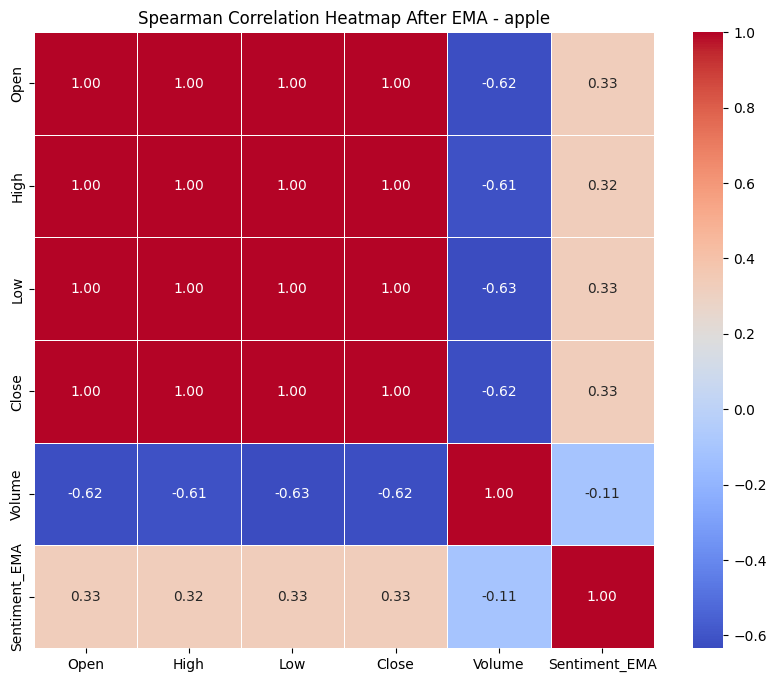

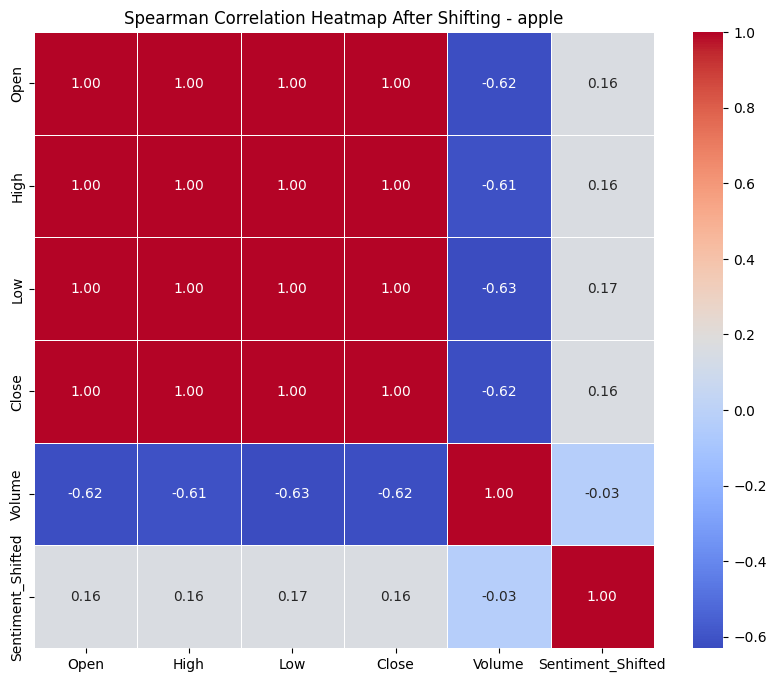

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_spearman_correlation_heatmap_after_ema(df, model_results, stock_name):
    # Obtener el mejor lag según el AIC para la variable 'Sentiment'
    best_lag_aic = model_results['Best Lag AIC']

    # Aplicar el EMA con el mejor lag a la variable 'Sentiment'
    ema_sentiment = df['Sentiment'].ewm(span=best_lag_aic, adjust=False).mean()

    # Reorganizar el DataFrame para que 'Close', 'Low' y 'Volume' estén en las últimas columnas
    ema_df = pd.concat([df[['Open', 'High', 'Low', 'Close', 'Volume']], ema_sentiment], axis=1)
    ema_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment_EMA']

    # Calcular la matriz de correlación de Spearman
    spearman_correlation_matrix = ema_df.corr(method='spearman')

    # Visualizar la matriz de correlación de Spearman
    plt.figure(figsize=(10, 8))
    sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f"Spearman Correlation Heatmap After EMA - {stock_name}")
    plt.show()
    return ema_df

def calculate_spearman_correlation_heatmap_after_shift(df, model_results, stock_name):
    # Obtener el mejor lag según el AIC para la variable 'Sentiment'
    best_lag_aic = model_results['Best Lag AIC']

    # Aplicar el shift (desplazamiento) con el mejor lag a la variable 'Sentiment'
    shifted_sentiment = df['Sentiment'].shift(best_lag_aic)

    # Reorganizar el DataFrame para que 'Close', 'Low' y 'Volume' estén en las últimas columnas
    shifted_df = pd.concat([df[['Open', 'High', 'Low', 'Close', 'Volume']], shifted_sentiment], axis=1)
    shifted_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment_Shifted']
    shifted_df = shifted_df.dropna()  # Eliminar filas con valores NaN

    # Calcular la matriz de correlación de Spearman
    spearman_correlation_matrix = shifted_df.corr(method='spearman')

    # Visualizar la matriz de correlación de Spearman
    plt.figure(figsize=(10, 8))
    sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f"Spearman Correlation Heatmap After Shifting - {stock_name}")
    plt.show()
    return shifted_df

#Ejemplo guardar
ema_values_apple_s=calculate_spearman_correlation_heatmap_after_ema(apple_s, model_results_apple, "apple")
shift_values_apple_s= calculate_spearman_correlation_heatmap_after_shift(apple_s, model_results_apple, "apple")



# LSTM

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn. preprocessing import MinMaxScaler
from sklearn import linear_model
from keras. models import Sequential
from keras. layers import Dense
import keras. backend as K
from keras. callbacks import EarlyStopping
from keras. optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from keras. models import load_model
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.utils import plot_model
import math

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import io
import time
import json

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

apple.set_index('Date', inplace=True)
apple_s.set_index('Date', inplace=True)

y = apple['Close']
X = apple.drop(columns=['Close'])

# Dividir los datos en conjunto de entrenamiento (60%), validación (20%) y conjunto de prueba (20%)
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train = X.iloc[:train_size]
X_val = X.iloc[train_size:train_size+val_size]
X_test = X.iloc[train_size+val_size:]

y_train = y.iloc[:train_size]
y_val = y.iloc[train_size:train_size+val_size]
y_test = y.iloc[train_size+val_size:]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

y_s = ema_values_apple_s['Close']
X_s = ema_values_apple_s.drop(columns=['Close'])
# Dividir los datos en conjunto de entrenamiento (60%), validación (20%) y conjunto de prueba (20%) para apple_s
train_size_s = int(len(X_s) * 0.6)
val_size_s = int(len(X_s) * 0.2)
test_size_s = len(X_s) - train_size_s - val_size_s

X_train_s = X_s.iloc[:train_size_s]
X_val_s = X_s.iloc[train_size_s:train_size_s+val_size_s]
X_test_s = X_s.iloc[train_size_s+val_size_s:]

y_train_s = y_s.iloc[:train_size_s]
y_val_s = y_s.iloc[train_size_s:train_size_s+val_size_s]
y_test_s = y_s.iloc[train_size_s+val_size_s:]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
y_s_s = shift_values_apple_s['Close']
X_s_s = shift_values_apple_s.drop(columns=['Close'])
# Dividir los datos en conjunto de entrenamiento (60%), validación (20%) y conjunto de prueba (20%) para apple_s
train_size_s_s = int(len(X_s_s) * 0.6)
val_size_s_s = int(len(X_s_s) * 0.2)
test_size_s_s = len(X_s) - train_size_s_s - val_size_s_s

X_train_s_s = X_s_s.iloc[:train_size_s_s]
X_val_s_s = X_s_s.iloc[train_size_s_s:train_size_s_s+val_size_s_s]
X_test_s_s = X_s_s.iloc[train_size_s_s+val_size_s_s:]

y_train_s_s = y_s_s.iloc[:train_size_s_s]
y_val_s_s = y_s_s.iloc[train_size_s_s:train_size_s_s+val_size_s_s]
y_test_s_s = y_s_s.iloc[train_size_s_s+val_size_s_s:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_train_test_val(X_train, y_train, X_test, y_test, X_val, y_val):
    # Convertir Series de Pandas a arreglos de NumPy
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    X_val_np = X_val.to_numpy()
    y_train_np = y_train.to_numpy()
    y_test_np = y_test.to_numpy()
    y_val_np = y_val.to_numpy()

    # Escalar características (X)
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train_np)
    X_test_scaled = scaler_X.transform(X_test_np)
    X_val_scaled = scaler_X.transform(X_val_np)

    # Escalar etiquetas (y)
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train_np.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test_np.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val_np.reshape(-1, 1)).flatten()

    return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, X_val_scaled, y_val_scaled, scaler_X, scaler_y

X_train, y_train, X_test, y_test, X_val, y_val, scaler_X, scaler_y = normalize_train_test_val(X_train, y_train, X_test, y_test, X_val, y_val)
X_train_s, y_train_s, X_test_s, y_test_s, X_val_s, y_val_s, scaler_X_s, scaler_y_s = normalize_train_test_val(X_train_s, y_train_s, X_test_s, y_test_s, X_val_s, y_val_s)
X_train_s_s, y_train_s_s, X_test_s_s, y_test_s_s, X_val_s_s, y_val_s_s, scaler_X_s_s, scaler_y_s_s = normalize_train_test_val(X_train_s_s, y_train_s_s, X_test_s_s, y_test_s_s, X_val_s_s, y_val_s_s)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Reshape de los datos para que sean compatibles con una red LSTM
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Verificar las formas de los datos después del reshape
print("Shape de trainX:", trainX.shape)
print("Shape de valX:", valX.shape)
print("Shape de testX:", testX.shape)



# Reshape de los datos para que sean compatibles con una red LSTM para apple_s
trainX_s = np.reshape(X_train_s, (X_train_s.shape[0], 1, X_train_s.shape[1]))
valX_s = np.reshape(X_val_s, (X_val_s.shape[0], 1, X_val_s.shape[1]))
testX_s = np.reshape(X_test_s, (X_test_s.shape[0], 1, X_test_s.shape[1]))

# Verificar las formas de los datos después del reshape para apple_s
print("Shape de trainX_s:", trainX_s.shape)
print("Shape de valX_s:", valX_s.shape)
print("Shape de testX_s:", testX_s.shape)


# Reshape de los datos para que sean compatibles con una red LSTM para apple_s_s
trainX_s_s = np.reshape(X_train_s_s, (X_train_s_s.shape[0], 1, X_train_s_s.shape[1]))
valX_s_s = np.reshape(X_val_s_s, (X_val_s_s.shape[0], 1, X_val_s_s.shape[1]))
testX_s_s = np.reshape(X_test_s_s, (X_test_s_s.shape[0], 1, X_test_s_s.shape[1]))

# Verificar las formas de los datos después del reshape para apple_s_s
print("Shape de trainX_s_s:", trainX_s_s.shape)
print("Shape de valX_s_s:", valX_s_s.shape)
print("Shape de testX_s_s:", testX_s_s.shape)





Shape de trainX: (666, 1, 4)
Shape de valX: (222, 1, 4)
Shape de testX: (223, 1, 4)
Shape de trainX_s: (666, 1, 5)
Shape de valX_s: (222, 1, 5)
Shape de testX_s: (223, 1, 5)
Shape de trainX_s_s: (661, 1, 5)
Shape de valX_s_s: (220, 1, 5)
Shape de testX_s_s: (221, 1, 5)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Grid search

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras_tuner.tuners import Hyperband
import matplotlib.pyplot as plt
import random
import os



def lstm(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=50, max_value=150, step=25),
                   input_shape=(1, 4),
                   activation='relu',
                   return_sequences=True))
    model.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=25, max_value=75, step=25),
                   activation='relu',
                   return_sequences=True))
    model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def lstm_s(hp):
    model_s = Sequential()
    model_s.add(LSTM(units=hp.Int('units1', min_value=50, max_value=150, step=25),
                   input_shape=(1, 5),
                   activation='relu',
                   return_sequences=True))
    model_s.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.3, step=0.1)))
    model_s.add(LSTM(units=hp.Int('units2', min_value=25, max_value=75, step=25),
                   activation='relu',
                   return_sequences=True))
    model_s.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.3, step=0.1)))
    model_s.add(Dense(1))

    optimizer_s = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model_s.compile(loss='mean_squared_error', optimizer=optimizer_s)

    return model_s
def lstm_s_s(hp_s):
    model_s_s = Sequential()
    model_s_s.add(LSTM(units=hp_s.Int('units1_s', min_value=50, max_value=150, step=25),
                   input_shape=(1, 5),
                   activation='relu',
                   return_sequences=True))
    model_s_s.add(Dropout(hp_s.Float('dropout1_s', min_value=0.1, max_value=0.3, step=0.1)))
    model_s_s.add(LSTM(units=hp_s.Int('units2_s', min_value=25, max_value=75, step=25),
                   activation='relu',
                   return_sequences=True))
    model_s_s.add(Dropout(hp_s.Float('dropout2_s', min_value=0.1, max_value=0.3, step=0.1)))
    model_s_s.add(Dense(1))

    optimizer_s_s = Adam(learning_rate=hp_s.Choice('learning_rate_s', values=[1e-2, 1e-3, 1e-4]))
    model_s_s.compile(loss='mean_squared_error', optimizer=optimizer_s_s)
    return model_s_s


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)

tuner = Hyperband(
    lstm,
    objective='val_loss',
    max_epochs=20,
    seed=2024,
    factor=3,
    directory='hyperband',
    project_name='lstm_hyperband'
)
tuner_s = Hyperband(
    lstm_s,
    objective='val_loss',
    max_epochs=20,
    seed=2024,
    factor=3,
    directory='hyperband',
    project_name='lstm_s_hyperband'
)

tuner_s_s = Hyperband(
    lstm_s_s,
    objective='val_loss',
    max_epochs=20,
    seed=2024,
    factor=3,
    directory='hyperband',
    project_name='lstm_s_s_hyperband'
)



tuner.search(trainX, y_train,
             epochs=64,
             validation_data=(valX, y_val),
             batch_size=32)
tuner_s.search(trainX_s, y_train_s,
             epochs=64,
             validation_data=(valX_s, y_val_s),
               batch_size=32)
tuner_s_s.search(trainX_s_s, y_train_s_s,
             epochs=64,
             validation_data=(valX_s_s, y_val_s_s),
               batch_size=32)

Trial 30 Complete [00h 00m 09s]
val_loss: 0.06004076078534126

Best val_loss So Far: 0.03417753800749779
Total elapsed time: 00h 03m 30s


In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp_s = tuner_s.get_best_hyperparameters(num_trials=1)[0]
best_hp_s_s = tuner_s_s.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hp.values}")
print(f"Best Hyperparameters_s: {best_hp_s.values}")
print(f"Best Hyperparameters_s_s: {best_hp_s_s.values}")

Best Hyperparameters: {'units1': 100, 'dropout1': 0.1, 'units2': 50, 'dropout2': 0.1, 'learning_rate': 0.001, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Best Hyperparameters_s: {'units1': 125, 'dropout1': 0.1, 'units2': 50, 'dropout2': 0.2, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Best Hyperparameters_s_s: {'units1_s': 150, 'dropout1_s': 0.1, 'units2_s': 25, 'dropout2_s': 0.2, 'learning_rate_s': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [ ]:
best_lstm = tuner.get_best_models(num_models=1)[0]
best_lstm.summary()
best_lstm_s = tuner_s.get_best_models(num_models=1)[0]
best_lstm_s.summary()
best_lstm_s_s = tuner_s_s.get_best_models(num_models=1)[0]
best_lstm_s_s.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            42000     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 dense (Dense)               (None, 1, 1)              51        
                                                                 
Total params: 72251 (282.23 KB)
Trainable params: 72251 (282.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential

###### Loss & Prediction

In [ ]:
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)
history1 = best_lstm.fit(trainX, y_train, epochs=64, batch_size=32, verbose=0, shuffle=False, validation_data=(valX, y_val))
history_s1 = best_lstm_s.fit(trainX_s, y_train_s, epochs=64, batch_size=32, verbose=0, shuffle=False, validation_data=(valX_s, y_val_s))
history_s1_s = best_lstm_s_s.fit(trainX_s_s, y_train_s_s, epochs=64, batch_size=32, verbose=0, shuffle=False, validation_data=(valX_s_s, y_val_s_s))

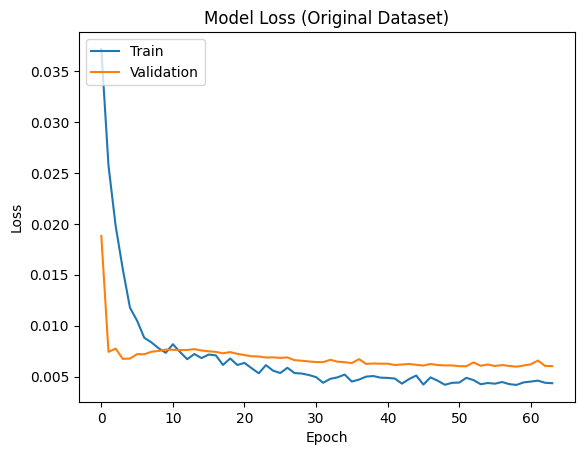

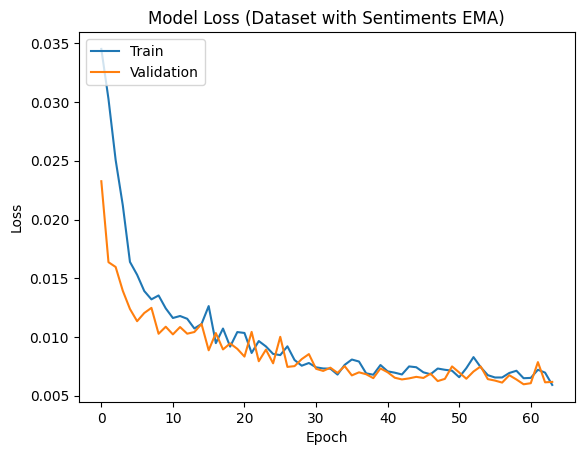

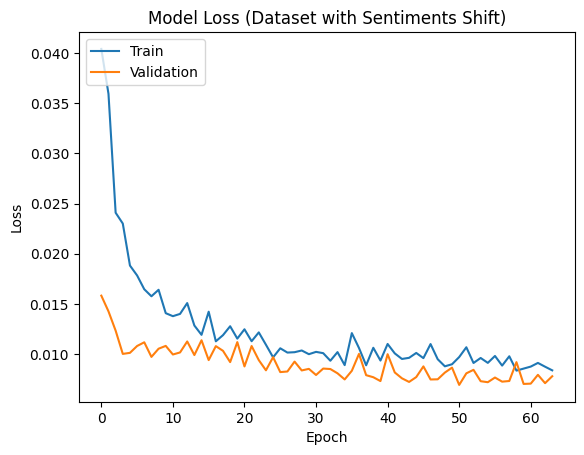

In [ ]:
# summarize history for loss and validation loss for the original dataset
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss (Original Dataset)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss and validation loss for the dataset with sentiments
plt.plot(history_s1.history['loss'])
plt.plot(history_s1.history['val_loss'])
plt.title('Model Loss (Dataset with Sentiments EMA)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss and validation loss for the dataset with sentiments
plt.plot(history_s1_s.history['loss'])
plt.plot(history_s1_s.history['val_loss'])
plt.title('Model Loss (Dataset with Sentiments Shift)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)

y_pred_LSTM= best_lstm.predict(testX)
y_pred_LSTM = np.squeeze(y_pred_LSTM)

y_pred_LSTM_s= best_lstm_s.predict(testX_s)
y_pred_LSTM_s = np.squeeze(y_pred_LSTM_s)

y_pred_LSTM_s_s= best_lstm_s_s.predict(testX_s_s)
y_pred_LSTM_s_s = np.squeeze(y_pred_LSTM_s_s)

7/7 [==============================] - 0s 4ms/step


###### Fig 6. Time series plots between the actual closing price and predicted closing price

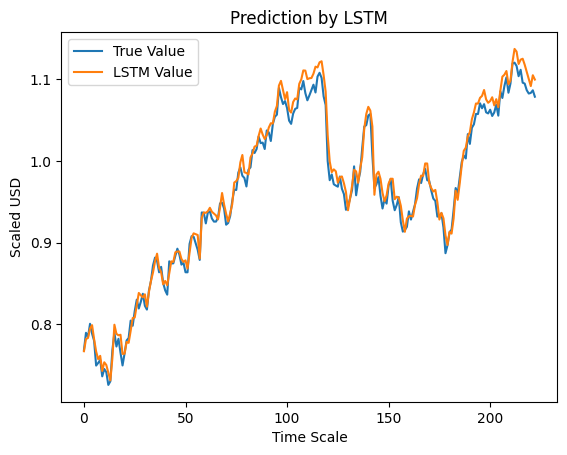

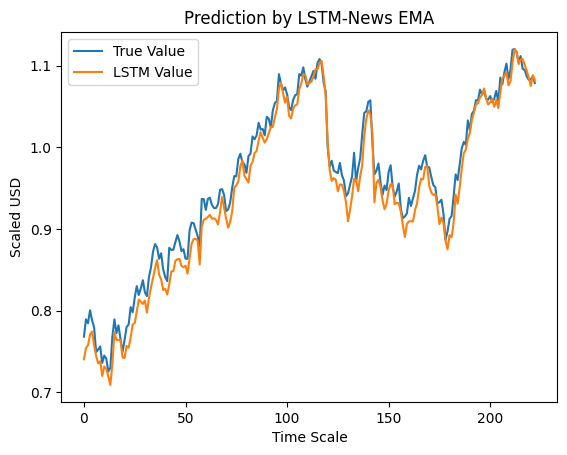

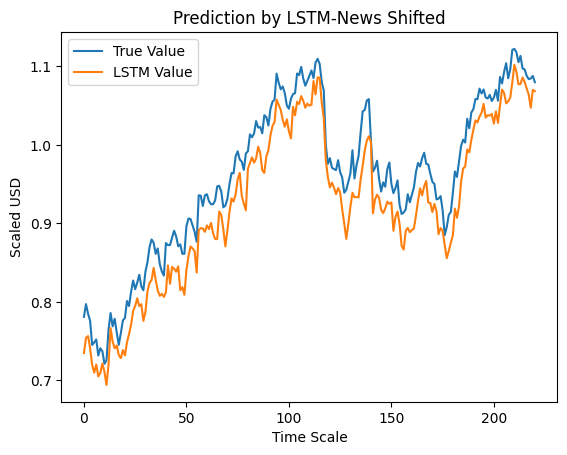

In [ ]:
# Step 12: Comparing Predicted vs True Adjusted Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred_LSTM, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

plt.plot(y_test_s, label='True Value')
plt.plot(y_pred_LSTM_s, label='LSTM Value')
plt.title('Prediction by LSTM-News EMA')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

plt.plot(y_test_s_s, label='True Value')
plt.plot(y_pred_LSTM_s_s, label='LSTM Value')
plt.title('Prediction by LSTM-News Shifted')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()


###### Table 6 desnormalizado

In [ ]:
def descale_y_data(y, scaler_y):
    y_descaled = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
    return y_descaled

y_train_descaled = descale_y_data(y_train, scaler_y)
y_val_descaled = descale_y_data(y_val, scaler_y)
y_test_descaled = descale_y_data(y_test, scaler_y)
y_pred_LSTM_descalated = descale_y_data(y_pred_LSTM, scaler_y)
y_pred_LSTM_s_descalated = descale_y_data(y_pred_LSTM_s, scaler_y)
y_pred_LSTM_s_s_descalated = descale_y_data(y_pred_LSTM_s_s, scaler_y)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


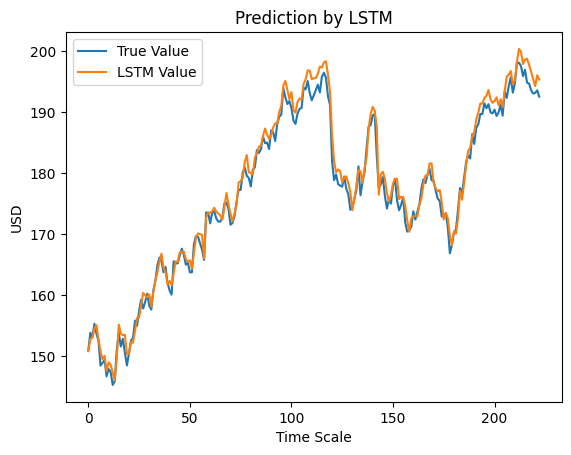

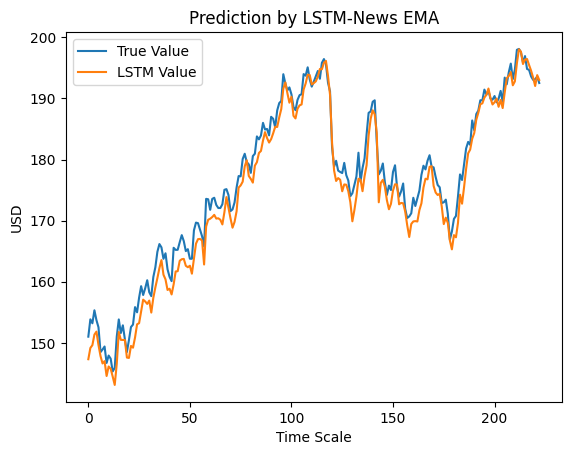

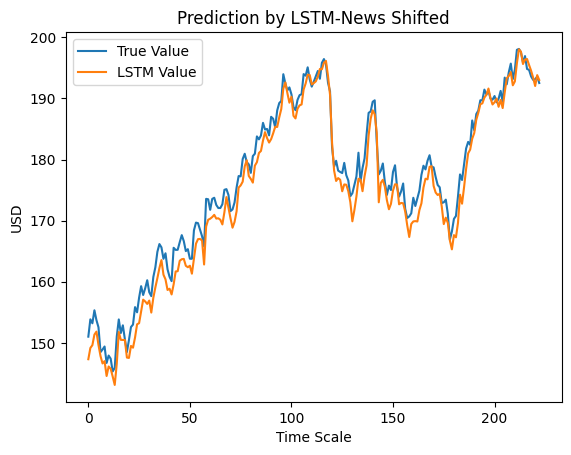

In [ ]:
plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_LSTM_descalated, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.show()

plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_LSTM_s_descalated, label='LSTM Value')
plt.title('Prediction by LSTM-News EMA')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.show()

plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_LSTM_s_descalated, label='LSTM Value')
plt.title('Prediction by LSTM-News Shifted')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.show()

###### Tabla metricas LSTM

In [ ]:
#R^2
r2_LSTM = r2_score(y_test, y_pred_LSTM)
# Cálculo de MSE
mse_LSTM = mean_squared_error(y_test, y_pred_LSTM)
# Cálculo de MAPE
pred_LSTM=y_pred_LSTM.flatten()
mape_LSTM = np.mean(np.abs((y_test - pred_LSTM) / y_test)) * 100
# Imprimir los resultados en una línea
print(f'Modelo normal: R^2: {r2_LSTM}, MSE: {mse_LSTM}, MAPE: {mape_LSTM}%')

#R^2
r2_LSTM_s = r2_score(y_test_s, y_pred_LSTM_s)
# Cálculo de MSE
mse_LSTM_s = mean_squared_error(y_test_s, y_pred_LSTM_s)
# Cálculo de MAPE
pred_LSTM_s=y_pred_LSTM_s.flatten()
mape_LSTM_s = np.mean(np.abs((y_test_s - pred_LSTM_s) / y_test_s)) * 100
# Imprimir los resultados en una línea
print(f'Modelo con News: R^2: {r2_LSTM_s}, MSE: {mse_LSTM_s}, MAPE: {mape_LSTM_s}%')

#R^2
r2_LSTM_s_s = r2_score(y_test_s_s, y_pred_LSTM_s_s)
# Cálculo de MSE
mse_LSTM_s_s = mean_squared_error(y_test_s_s, y_pred_LSTM_s_s)
# Cálculo de MAPE
pred_LSTM_s_s=y_pred_LSTM_s_s.flatten()
mape_LSTM_s_s = np.mean(np.abs((y_test_s_s - pred_LSTM_s_s) / y_test_s_s)) * 100
# Imprimir los resultados en una línea
print(f'Modelo con News: R^2: {r2_LSTM_s_s}, MSE: {mse_LSTM_s_s}, MAPE: {mape_LSTM_s_s}%')

Modelo normal: R^2: 0.9846397564866196, MSE: 0.00015510386585392648, MAPE: 1.0374900195120793%
Modelo con News: R^2: 0.9650784052217247, MSE: 0.00035262945845724827, MAPE: 1.727982130433994%
Modelo con News: R^2: 0.8605443635584183, MSE: 0.0014238505339211475, MAPE: 3.7507810502276056%


# GRU

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras_tuner.tuners import Hyperband
import matplotlib.pyplot as plt
import random
import os
# Función para asegurar la reproducibilidad
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    if tf.config.experimental.list_physical_devices('GPU'):
        # Configurar el uso de GPU para asegurar reproducibilidad
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)

# Establecer semilla para numpy, tensorflow y otras librerías relevantes
seed = 2024
set_seed(seed)

def gru(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units1', min_value=50, max_value=150, step=25),
                   input_shape=(1, 4),
                   activation='relu',
                   return_sequences=True))
    model.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(GRU(units=hp.Int('units2', min_value=25, max_value=75, step=25),
                   activation='relu',
                   return_sequences=True))
    model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def gru_s(hp):
    model_s = Sequential()
    model_s.add(GRU(units=hp.Int('units1', min_value=50, max_value=150, step=25),
                   input_shape=(1, 5),
                   activation='relu',
                   return_sequences=True))
    model_s.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.3, step=0.1)))
    model_s.add(GRU(units=hp.Int('units2', min_value=25, max_value=75, step=25),
                   activation='relu',
                   return_sequences=True))
    model_s.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.3, step=0.1)))
    model_s.add(Dense(1))

    optimizer_s = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model_s.compile(loss='mean_squared_error', optimizer=optimizer_s)
    return model_s

def gru_s_s(hp):
    model_s_s = Sequential()
    model_s_s.add(GRU(units=hp.Int('units1', min_value=50, max_value=150, step=25),
                   input_shape=(1, 5),
                   activation='relu',
                   return_sequences=True))
    model_s_s.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.3, step=0.1)))
    model_s_s.add(GRU(units=hp.Int('units2', min_value=25, max_value=75, step=25),
                   activation='relu',
                   return_sequences=True))
    model_s_s.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.3, step=0.1)))
    model_s_s.add(Dense(1))

    optimizer_s_s = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model_s_s.compile(loss='mean_squared_error', optimizer=optimizer_s_s)
    return model_s_s



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)

tuner = Hyperband(
    gru,
    objective='val_loss',
    max_epochs=20,
    seed=2024,
    factor=3,
    directory='hyperband',
    project_name='gru_hyperband'
)
tuner_s = Hyperband(
    gru_s,
    objective='val_loss',
    max_epochs=20,
    seed=2024,
    factor=3,
    directory='hyperband',
    project_name='gru_s_hyperband'
)

tuner_s_s = Hyperband(
    gru_s_s,
    objective='val_loss',
    max_epochs=20,
    seed=2024,
    factor=3,
    directory='hyperband',
    project_name='gru_s_s_hyperband'
)

tuner.search(trainX, y_train,
             epochs=64,
             validation_data=(valX, y_val),
             batch_size=32)
tuner_s.search(trainX_s, y_train_s,
             epochs=64,
             validation_data=(valX_s, y_val_s),
               batch_size=32)
tuner_s_s.search(trainX_s_s, y_train_s_s,
             epochs=64,
             validation_data=(valX_s_s, y_val_s_s),
               batch_size=32)

Trial 30 Complete [00h 00m 12s]
val_loss: 0.04391036555171013

Best val_loss So Far: 0.029089806601405144
Total elapsed time: 00h 05m 05s


In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp_s = tuner_s.get_best_hyperparameters(num_trials=1)[0]
best_hp_s_s = tuner_s_s.get_best_hyperparameters(num_trials=1)[0]


print(f"Best Hyperparameters: {best_hp.values}")
print(f"Best Hyperparameters_s: {best_hp_s.values}")
print(f"Best Hyperparameters_s_s: {best_hp_s_s.values}")

Best Hyperparameters: {'units1': 100, 'dropout1': 0.1, 'units2': 50, 'dropout2': 0.1, 'learning_rate': 0.001, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Best Hyperparameters_s: {'units1': 100, 'dropout1': 0.2, 'units2': 25, 'dropout2': 0.1, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Best Hyperparameters_s_s: {'units1': 100, 'dropout1': 0.2, 'units2': 25, 'dropout2': 0.1, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [ ]:
best_gru = tuner.get_best_models(num_models=1)[0]
best_gru.summary()
best_gru_s = tuner_s.get_best_models(num_models=1)[0]
best_gru_s.summary()
best_gru_s_s = tuner_s_s.get_best_models(num_models=1)[0]
best_gru_s_s.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 100)            31800     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 gru_1 (GRU)                 (None, 1, 50)             22800     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 dense (Dense)               (None, 1, 1)              51        
                                                                 
Total params: 54651 (213.48 KB)
Trainable params: 54651 (213.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential

###### Loss and prediction

In [ ]:
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)

history = best_gru.fit(trainX, y_train, epochs=64, batch_size=32, verbose=0, shuffle=False, validation_data=(valX, y_val))
history_s = best_gru_s.fit(trainX_s, y_train_s, epochs=64, batch_size=32, verbose=0, shuffle=False, validation_data=(valX_s, y_val_s))
history_s_s = best_gru_s_s.fit(trainX_s_s, y_train_s_s, epochs=64, batch_size=32, verbose=0, shuffle=False, validation_data=(valX_s_s, y_val_s_s))

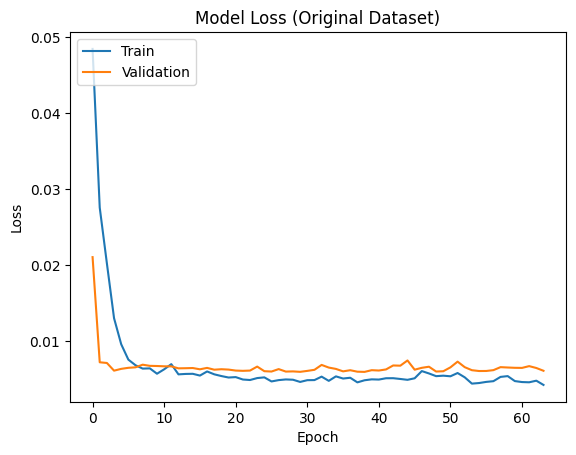

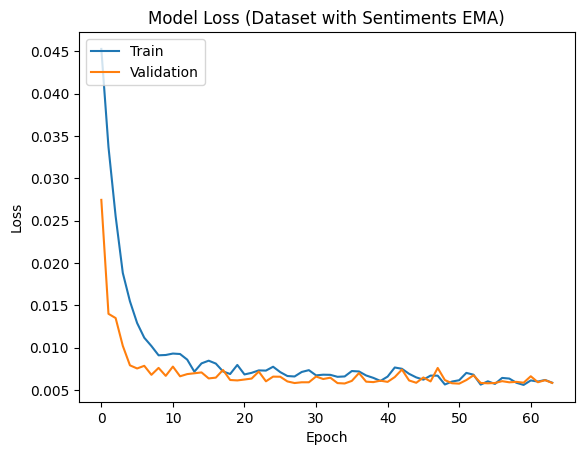

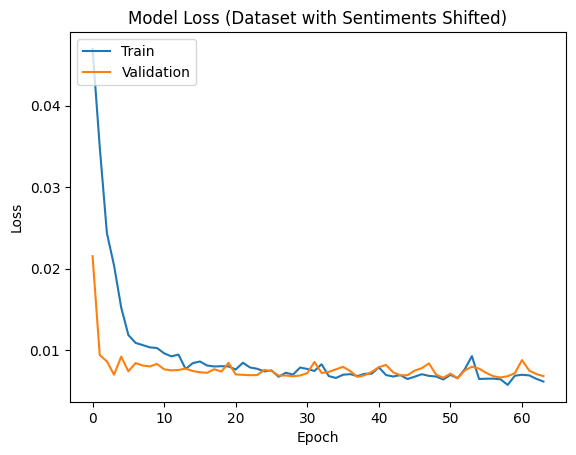

In [ ]:
# summarize history for loss and validation loss for the original dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (Original Dataset)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss and validation loss for the dataset with sentiments
plt.plot(history_s.history['loss'])
plt.plot(history_s.history['val_loss'])
plt.title('Model Loss (Dataset with Sentiments EMA)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss and validation loss for the dataset with sentiments
plt.plot(history_s_s.history['loss'])
plt.plot(history_s_s.history['val_loss'])
plt.title('Model Loss (Dataset with Sentiments Shifted)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)

y_pred_GRU= best_gru.predict(testX)
y_pred_GRU = np.squeeze(y_pred_GRU)

y_pred_GRU_s= best_gru_s.predict(testX_s)
y_pred_GRU_s = np.squeeze(y_pred_GRU_s)

y_pred_GRU_s_s= best_gru_s_s.predict(testX_s_s)
y_pred_GRU_s_s = np.squeeze(y_pred_GRU_s_s)

7/7 [==============================] - 1s 6ms/step


### Fig 6. Time series plots between the actual closing price and predicted closing price

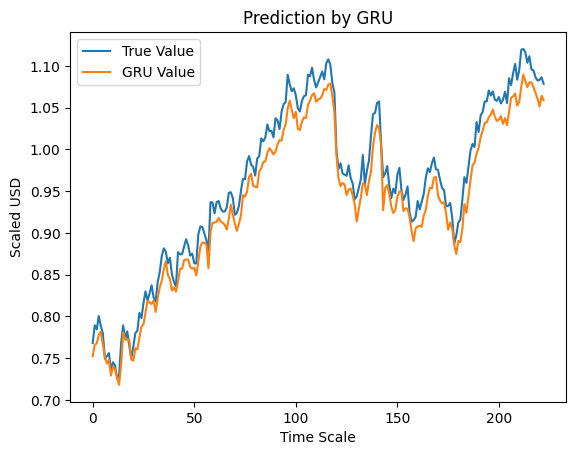

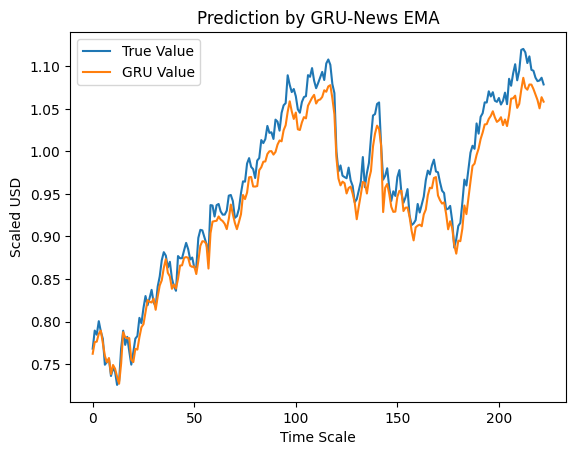

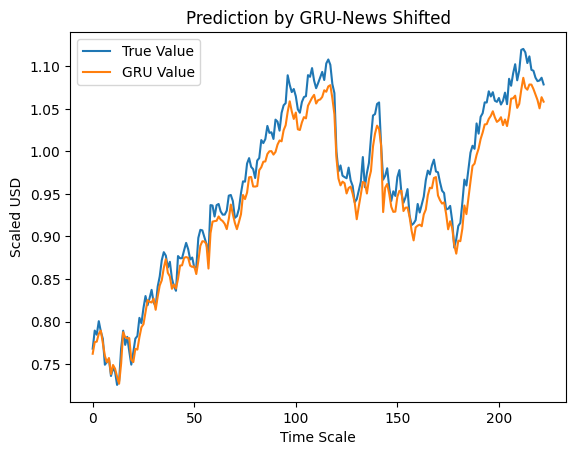

In [ ]:
# Step 12: Comparing Predicted vs True Adjusted Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred_GRU, label='GRU Value')
plt.title('Prediction by GRU')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

plt.plot(y_test_s, label='True Value')
plt.plot(y_pred_GRU_s, label='GRU Value')
plt.title('Prediction by GRU-News EMA')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

plt.plot(y_test_s, label='True Value')
plt.plot(y_pred_GRU_s, label='GRU Value')
plt.title('Prediction by GRU-News Shifted')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [ ]:
def descale_y_data(y, scaler_y):
    y_descaled = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
    return y_descaled

y_train_descaled = descale_y_data(y_train, scaler_y)
y_val_descaled = descale_y_data(y_val, scaler_y)
y_test_descaled = descale_y_data(y_test, scaler_y)
y_pred_GRU_descalated = descale_y_data(y_pred_GRU, scaler_y)
y_pred_GRU_s_descalated = descale_y_data(y_pred_GRU_s, scaler_y)
y_pred_GRU_s_s_descalated = descale_y_data(y_pred_GRU_s_s, scaler_y)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


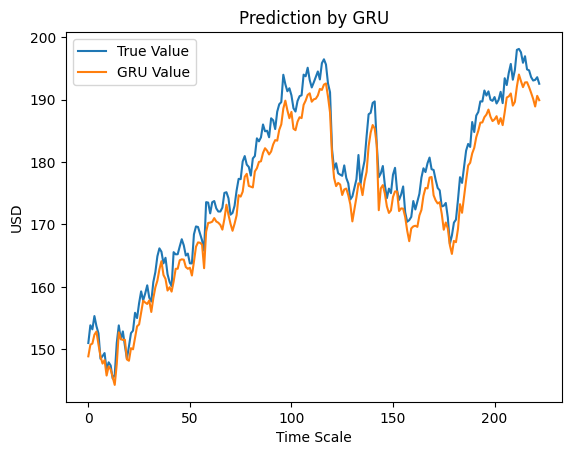

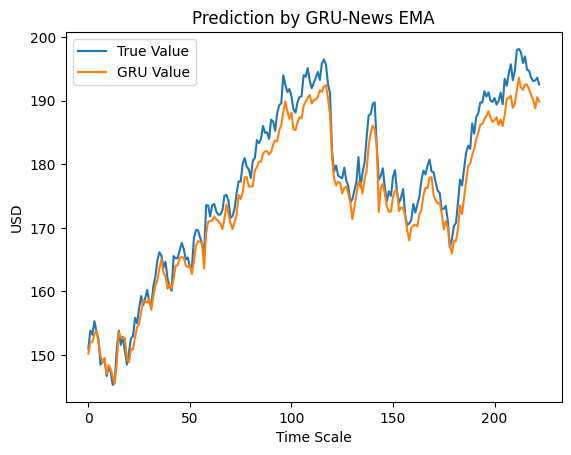

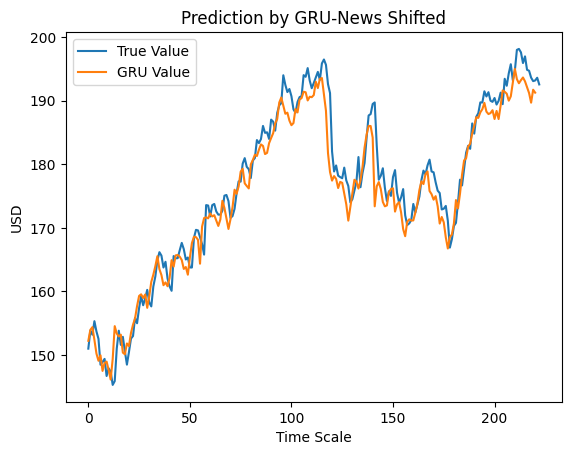

In [ ]:
plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_GRU_descalated, label='GRU Value')
plt.title('Prediction by GRU')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.show()

plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_GRU_s_descalated, label='GRU Value')
plt.title('Prediction by GRU-News EMA')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.show()

plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_GRU_s_s_descalated, label='GRU Value')
plt.title('Prediction by GRU-News Shifted')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.show()

In [ ]:
#R^2
r2_GRU = r2_score(y_test, y_pred_GRU)
# Cálculo de MSE
mse_GRU = mean_squared_error(y_test, y_pred_GRU)
# Cálculo de MAPE
pred_GRU=y_pred_GRU.flatten()
mape_GRU = np.mean(np.abs((y_test - pred_GRU) / y_test)) * 100
# Imprimir los resultados en una línea
print(f'Modelo normal: R^2: {r2_GRU}, MSE: {mse_GRU}, MAPE: {mape_GRU}%')

#R^2
r2_GRU_s = r2_score(y_test_s, y_pred_GRU_s)
# Cálculo de MSE
mse_GRU_s = mean_squared_error(y_test_s, y_pred_GRU_s)
# Cálculo de MAPE
pred_GRU_s=y_pred_GRU_s.flatten()
mape_GRU_s = np.mean(np.abs((y_test_s - pred_GRU_s) / y_test_s)) * 100
# Imprimir los resultados en una línea
print(f'Modelo con News EMA: R^2: {r2_GRU_s}, MSE: {mse_GRU_s}, MAPE: {mape_GRU_s}%')

#R^2
r2_GRU_s_s = r2_score(y_test_s_s, y_pred_GRU_s_s)
# Cálculo de MSE
mse_GRU_s_s = mean_squared_error(y_test_s_s, y_pred_GRU_s_s)
# Cálculo de MAPE
pred_GRU_s_s=y_pred_GRU_s_s.flatten()
mape_GRU_s_s = np.mean(np.abs((y_test_s_s - pred_GRU_s_s) / y_test_s_s)) * 100
# Imprimir los resultados en una línea
print(f'Modelo con News Shifted: R^2: {r2_GRU_s_s}, MSE: {mse_GRU_s_s}, MAPE: {mape_GRU_s_s}%')

Modelo normal: R^2: 0.9447758619883531, MSE: 0.0005576394206638563, MAPE: 2.2101994832693883%
Modelo con News EMA: R^2: 0.954575463441549, MSE: 0.0004586855161964954, MAPE: 1.8920959888220235%
Modelo con News Shifted: R^2: 0.9701804440298814, MSE: 0.00030445948097000057, MAPE: 1.5046374269159537%


# Loss y predicciones unidos

### Normal y *EMA*

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


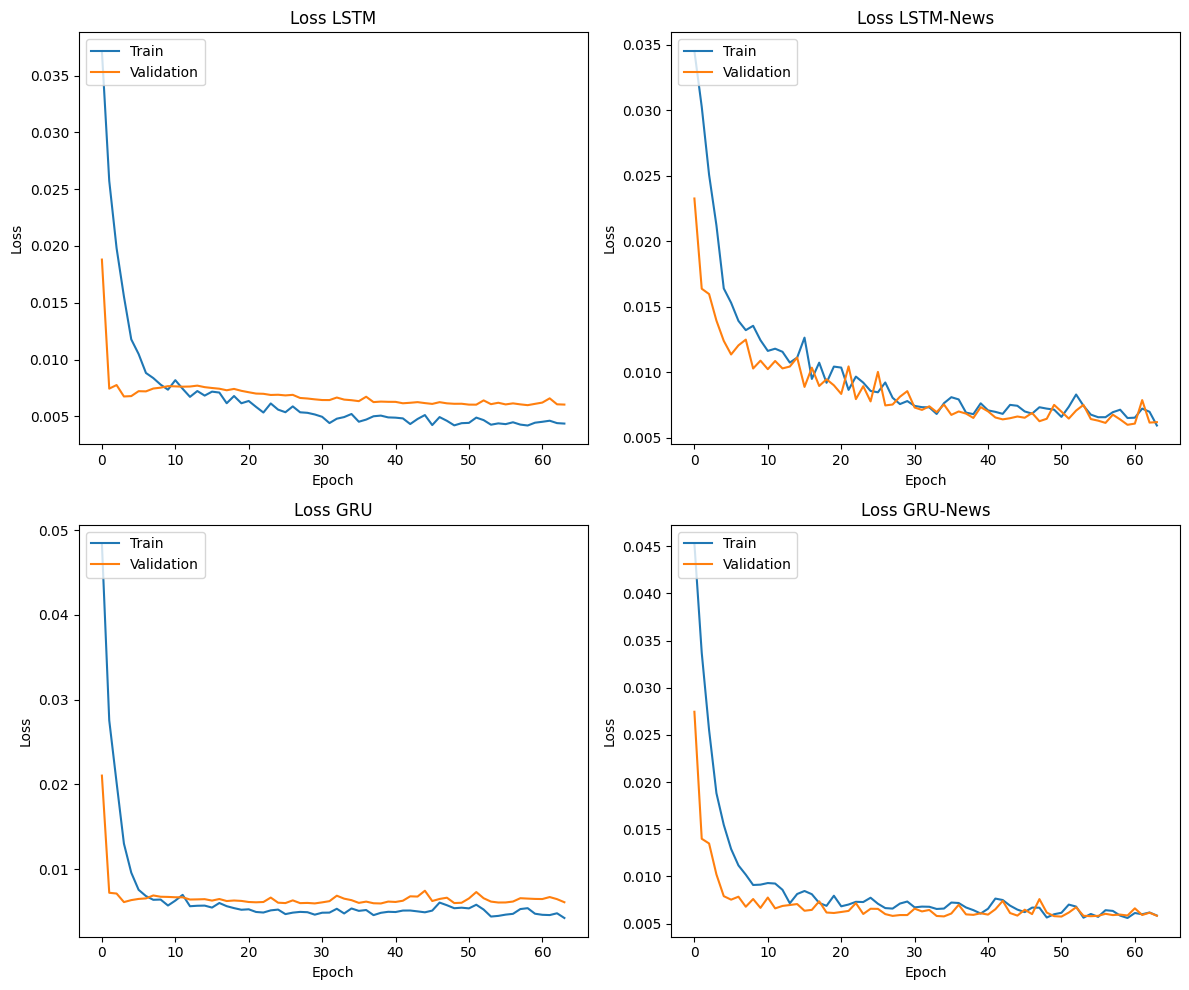

In [ ]:
import matplotlib.pyplot as plt

# Establecer el tamaño de la figura
plt.figure(figsize=(12, 10))

# Primer gráfico: Model Loss LSTM
plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Segundo gráfico: Model Loss LSTM-News
plt.subplot(2, 2, 2)
plt.plot(history_s1.history['loss'])
plt.plot(history_s1.history['val_loss'])
plt.title('Loss LSTM-News')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Tercer gráfico: Model Loss GRU
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss GRU')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Cuarto gráfico: Model Loss GRU-News
plt.subplot(2, 2, 4)
plt.plot(history_s.history['loss'])
plt.plot(history_s.history['val_loss'])
plt.title('Loss GRU-News')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()
plt.show()


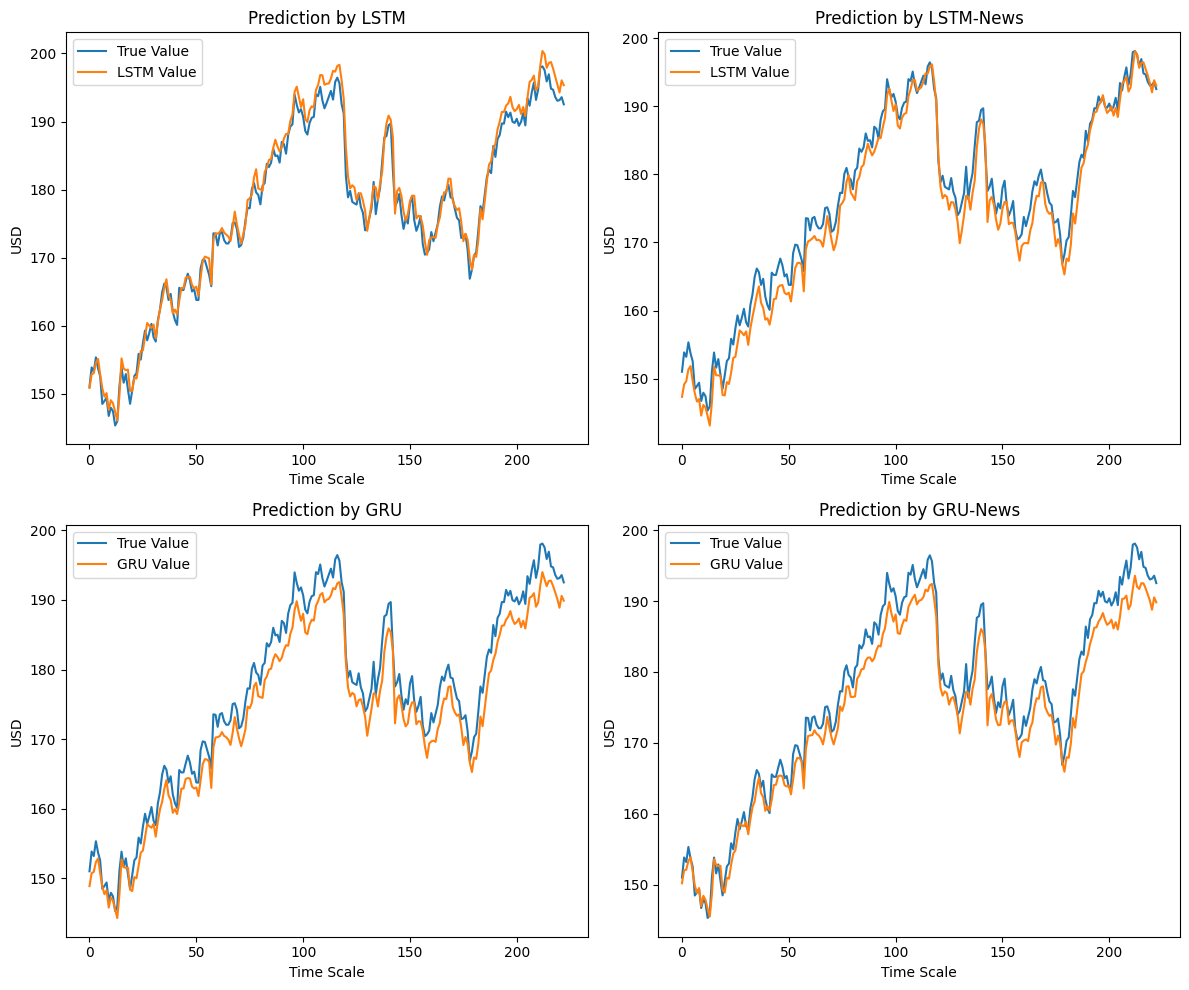

In [ ]:
import matplotlib.pyplot as plt

# Establecer el tamaño de la figura
plt.figure(figsize=(12, 10))

# Primer gráfico
plt.subplot(2, 2, 1)
plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_LSTM_descalated, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()

# Segundo gráfico
plt.subplot(2, 2, 2)
plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_LSTM_s_descalated, label='LSTM Value')
plt.title('Prediction by LSTM-News')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()

# Tercer gráfico
plt.subplot(2, 2, 3)
plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_GRU_descalated, label='GRU Value')
plt.title('Prediction by GRU')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()

# Cuarto gráfico
plt.subplot(2, 2, 4)
plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_GRU_s_descalated, label='GRU Value')
plt.title('Prediction by GRU-News')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()
plt.show()


### Normal y shifted

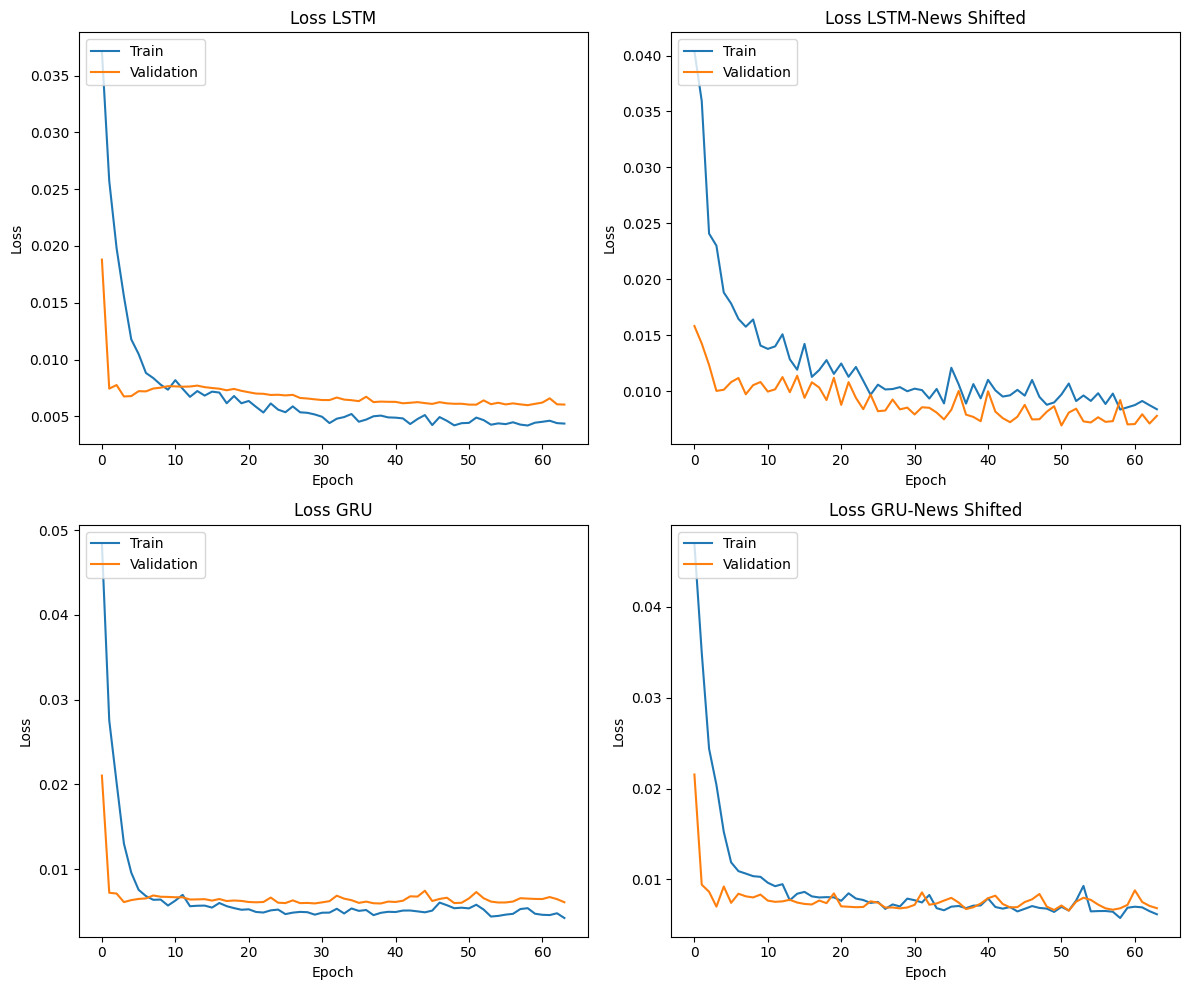

In [ ]:
import matplotlib.pyplot as plt

# Establecer el tamaño de la figura
plt.figure(figsize=(12, 10))

# Primer gráfico: Model Loss LSTM
plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Segundo gráfico: Model Loss LSTM-News
plt.subplot(2, 2, 2)
plt.plot(history_s1_s.history['loss'])
plt.plot(history_s1_s.history['val_loss'])
plt.title('Loss LSTM-News Shifted')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Tercer gráfico: Model Loss GRU
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss GRU')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Cuarto gráfico: Model Loss GRU-News
plt.subplot(2, 2, 4)
plt.plot(history_s_s.history['loss'])
plt.plot(history_s_s.history['val_loss'])
plt.title('Loss GRU-News Shifted')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()
plt.show()


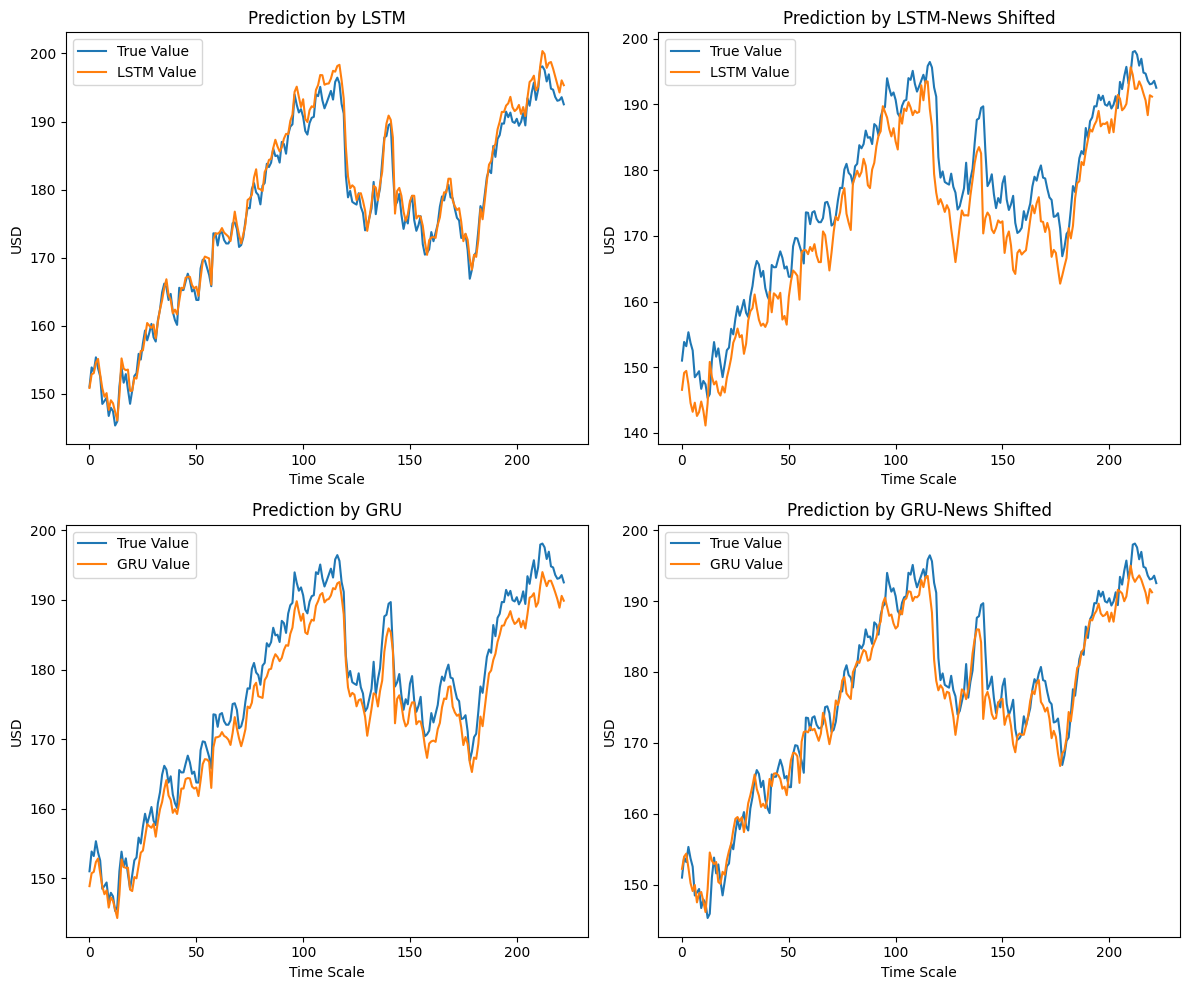

In [ ]:
import matplotlib.pyplot as plt

# Establecer el tamaño de la figura
plt.figure(figsize=(12, 10))

# Primer gráfico
plt.subplot(2, 2, 1)
plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_LSTM_descalated, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()

# Segundo gráfico
plt.subplot(2, 2, 2)
plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_LSTM_s_s_descalated, label='LSTM Value')
plt.title('Prediction by LSTM-News Shifted')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()

# Tercer gráfico
plt.subplot(2, 2, 3)
plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_GRU_descalated, label='GRU Value')
plt.title('Prediction by GRU')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()

# Cuarto gráfico
plt.subplot(2, 2, 4)
plt.plot(y_test_descaled, label='True Value')
plt.plot(y_pred_GRU_s_s_descalated, label='GRU Value')
plt.title('Prediction by GRU-News Shifted')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()
plt.show()


### Las 3

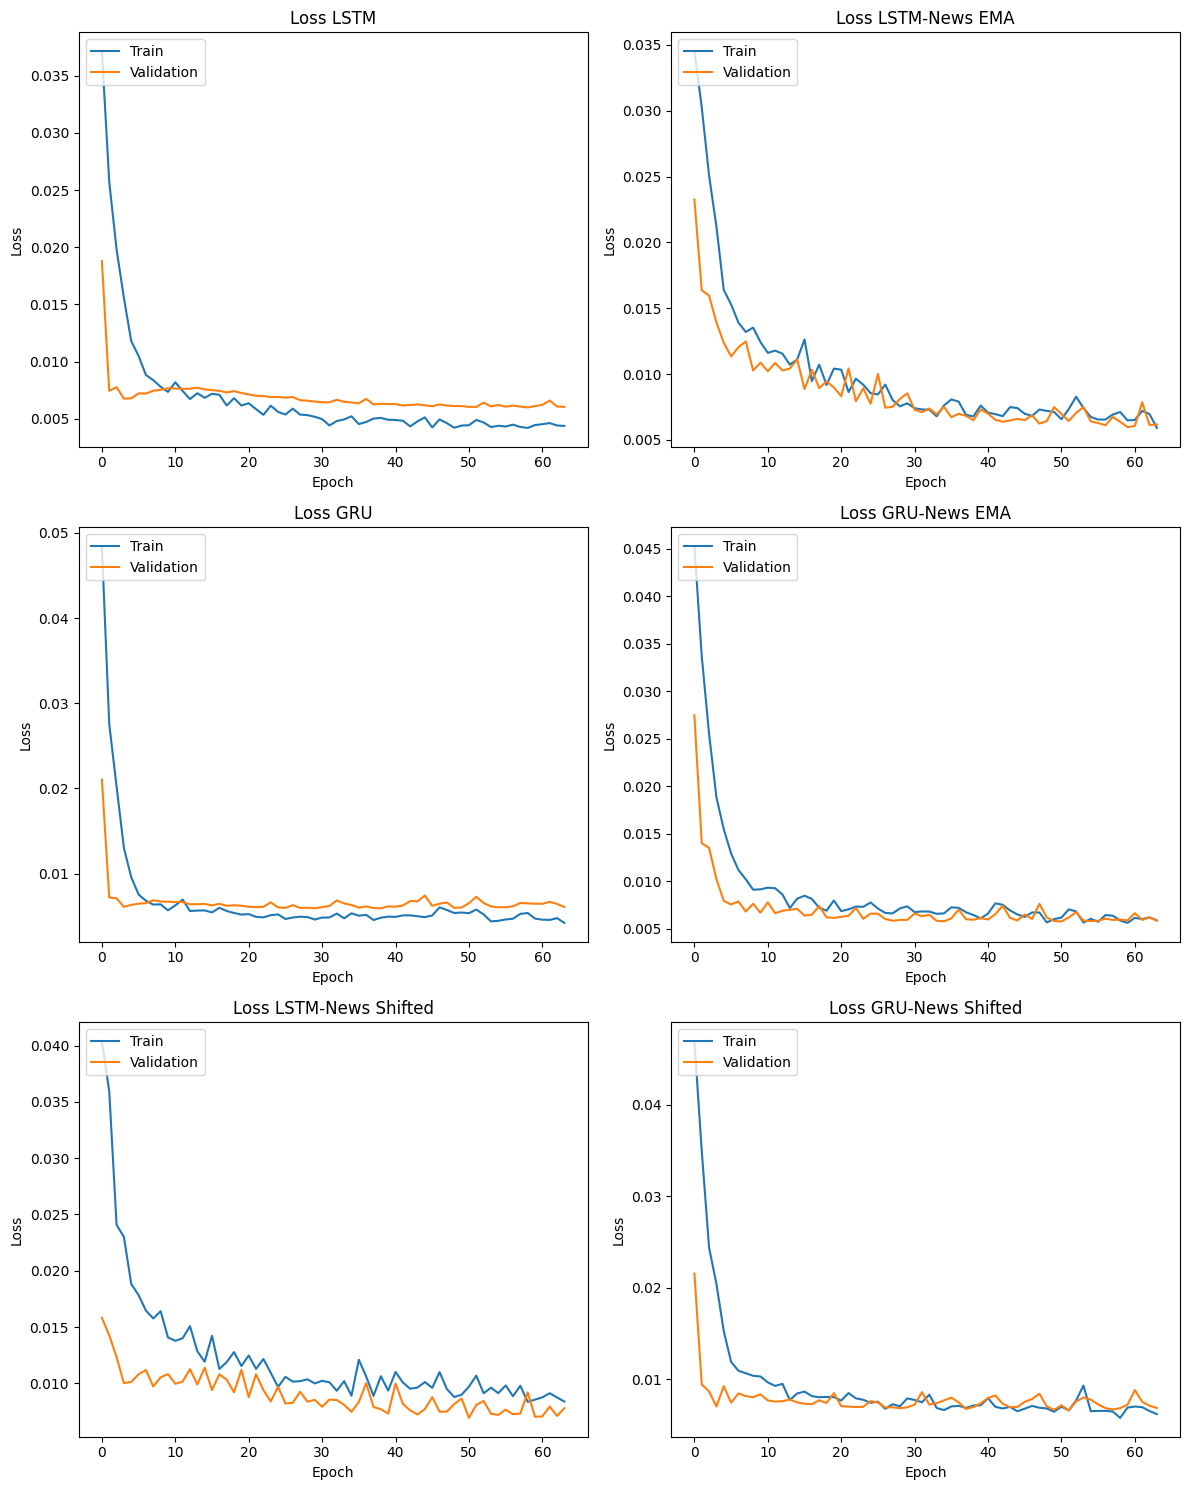

In [ ]:
import matplotlib.pyplot as plt

# Establecer el tamaño de la figura
plt.figure(figsize=(12, 15))

# Primer gráfico: Model Loss LSTM
plt.subplot(3, 2, 1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Segundo gráfico: Model Loss LSTM-News
plt.subplot(3, 2, 2)
plt.plot(history_s1.history['loss'])
plt.plot(history_s1.history['val_loss'])
plt.title('Loss LSTM-News EMA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Tercer gráfico: Model Loss GRU
plt.subplot(3, 2, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss GRU')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Cuarto gráfico: Model Loss GRU-News
plt.subplot(3, 2, 4)
plt.plot(history_s.history['loss'])
plt.plot(history_s.history['val_loss'])
plt.title('Loss GRU-News EMA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Quinto gráfico: Model Loss LSTM-News Shifted
plt.subplot(3, 2, 5)
plt.plot(history_s1_s.history['loss'])
plt.plot(history_s1_s.history['val_loss'])
plt.title('Loss LSTM-News Shifted')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Sexto gráfico: Model Loss GRU-News Shifted
plt.subplot(3, 2, 6)
plt.plot(history_s_s.history['loss'])
plt.plot(history_s_s.history['val_loss'])
plt.title('Loss GRU-News Shifted')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()
plt.show()


# Fig 5. Scatter plots between the actual closing price and predicted closing price (Errores)

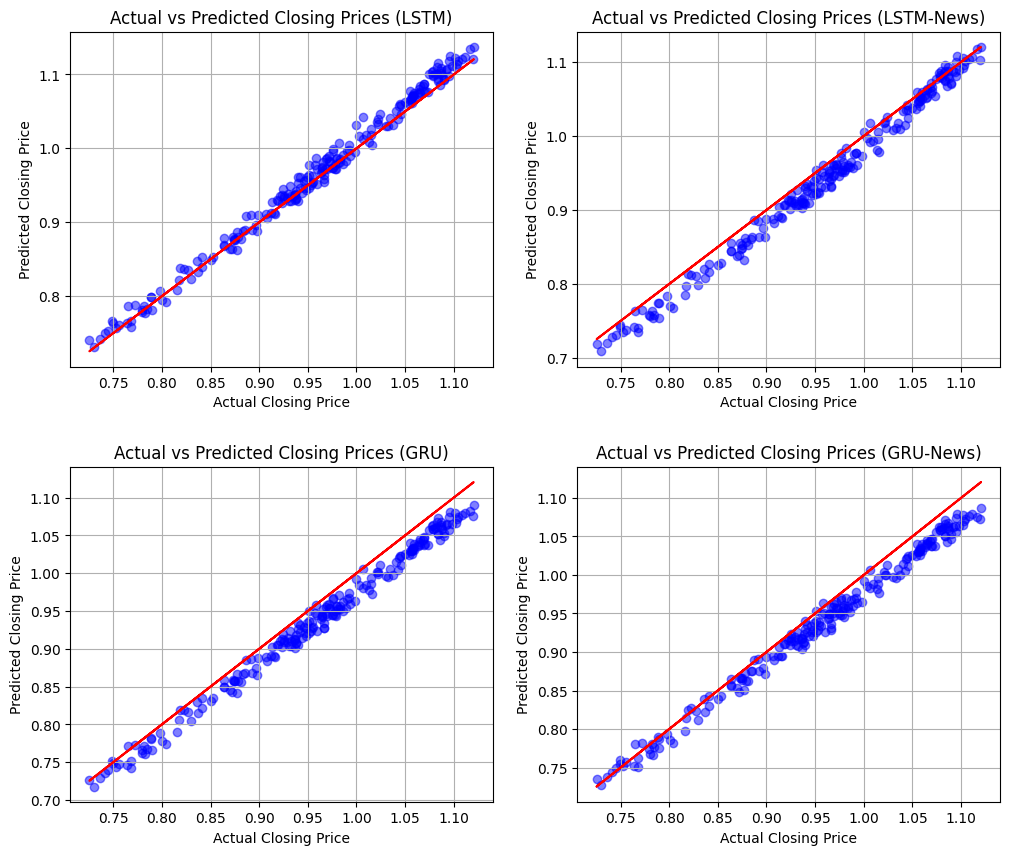

In [ ]:
import matplotlib.pyplot as plt

def scatter_plot_actual_vs_predicted_multiple(actual_prices_list, predicted_prices_list, model_names):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.subplots_adjust(hspace=0.3)

    for i, (actual_prices, predicted_prices, model_name) in enumerate(zip(actual_prices_list, predicted_prices_list, model_names)):
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        ax.scatter(actual_prices, predicted_prices, color='blue', alpha=0.5)
        ax.plot(actual_prices, actual_prices, color='red', linestyle='-')
        ax.set_title(f'Actual vs Predicted Closing Prices ({model_name})')
        ax.set_xlabel('Actual Closing Price')
        ax.set_ylabel('Predicted Closing Price')
        ax.grid(True)

    plt.show()

actual_prices_list = [y_test, y_test_s, y_test, y_test_s]
predicted_prices_list = [y_pred_LSTM, y_pred_LSTM_s, y_pred_GRU, y_pred_GRU_s]
model_names = ['LSTM', 'LSTM-News', 'GRU', 'GRU-News']

scatter_plot_actual_vs_predicted_multiple(actual_prices_list, predicted_prices_list, model_names)

### Table 7. Model performance metrics of four models obtained using test datasets

In [ ]:
from tabulate import tabulate

data = [
    ["RMSE", mse_LSTM,mse_GRU, mse_LSTM_s, mse_GRU_s],
    ["R", r2_LSTM, r2_GRU, r2_LSTM_s, r2_GRU_s],
    ["MAPE", mape_LSTM, mape_GRU, mape_LSTM_s, mape_GRU_s]
]

headers = ["Model", "LSTM", "GRU","LSTM-News", "GRU-News"]

print(tabulate(data, headers=headers, tablefmt="fancy_grid"))


╒═════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ Model   │        LSTM │         GRU │   LSTM-News │    GRU-News │
╞═════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ RMSE    │ 0.000155104 │ 0.000557639 │ 0.000352629 │ 0.000458686 │
├─────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ R       │ 0.98464     │ 0.944776    │ 0.965078    │ 0.954575    │
├─────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ MAPE    │ 1.03749     │ 2.2102      │ 1.72798     │ 1.8921      │
╘═════════╧═════════════╧═════════════╧═════════════╧═════════════╛


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


### Parametric test (Para hacer ANOVA la data ha de seguir una Normal)

###### 1. QQ plot

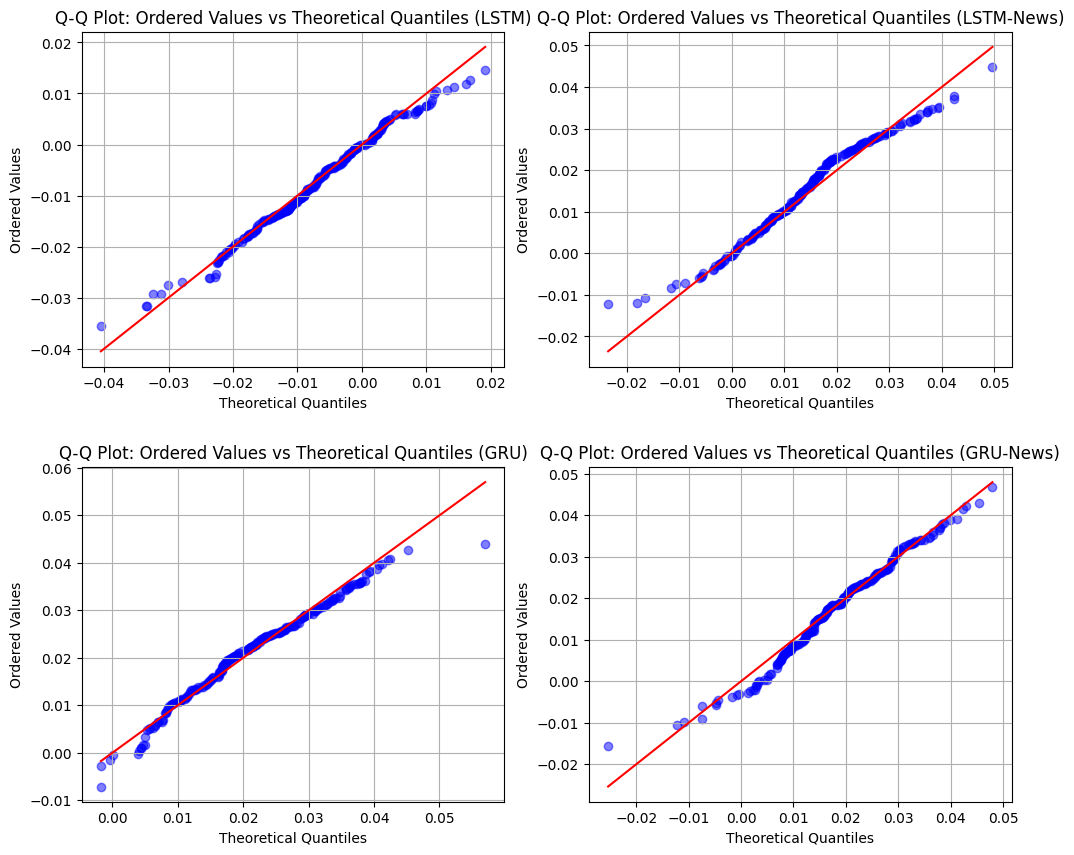

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def qq_plots_multiple(ordered_values_list, model_names):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.subplots_adjust(hspace=0.3)

    for i, (ordered_values, model_name) in enumerate(zip(ordered_values_list, model_names)):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        # Generar cuantiles teóricos para dist normal
        mean = np.mean(ordered_values)
        std_dev = np.std(ordered_values)
        theoretical_quantiles = np.random.normal(loc=mean, scale=std_dev, size=len(ordered_values))
        theoretical_quantiles = np.sort(theoretical_quantiles)

        # Ordenar valores
        ordered_values = np.sort(ordered_values)

        # Q-Q plot
        ax.scatter(theoretical_quantiles, ordered_values, color='blue', alpha=0.5)
        ax.plot([np.min(theoretical_quantiles), np.max(theoretical_quantiles)], [np.min(theoretical_quantiles), np.max(theoretical_quantiles)], color='red')
        ax.set_title(f'Q-Q Plot: Ordered Values vs Theoretical Quantiles ({model_name})')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Ordered Values')
        ax.grid(True)

    plt.show()

qq_apple_LSTM = (y_test - pred_LSTM)
qq_apple_LSTM_s = (y_test_s - pred_LSTM_s)
qq_apple_GRU = (y_test - pred_GRU)
qq_apple_GRU_s = (y_test_s - pred_GRU_s)

qq_apple = [qq_apple_LSTM, qq_apple_LSTM_s, qq_apple_GRU, qq_apple_GRU_s]
model_names = ['LSTM', 'LSTM-News', 'GRU', 'GRU-News']

qq_plots_multiple(qq_apple, model_names)


###### 2. Test Normality (Agostino K-squared test)

In [ ]:
from scipy.stats import normaltest

def d_agostino_test(datasets, alpha=0.05):
    resultados = []

    for i, data in enumerate(datasets, start=1):
        statistic, p_value = normaltest(data)
        normalidad = p_value > alpha
        resultados.append((f'Dataset {i}', statistic, p_value, normalidad))

    return resultados

qq_apple= [qq_apple_LSTM,qq_apple_LSTM_s,qq_apple_GRU,qq_apple_GRU_s]

d_agostino_test(qq_apple)


[('Dataset 1', 3.577466833666481, 0.1671717725855192, True),
 ('Dataset 2', 6.009141772332643, 0.049560016654882355, False),
 ('Dataset 3', 3.6143056324199083, 0.16412075416566096, True),
 ('Dataset 4', 3.044994046575016, 0.21816643955807397, True)]

### Non-Parametric

###### 1. Kruskal Wallis test (que tipo de acuracy usar?)

In [ ]:
from scipy.stats import kruskal

LSTM = (y_test - pred_LSTM)
LSTM_s = (y_test_s - pred_LSTM_s)
GRU = (y_test - pred_GRU)
GRU_s = (y_test_s - pred_GRU_s)


statistic, p_value = kruskal(LSTM,LSTM_s,GRU,GRU_s)

print("Test de Kruskal-Wallis:")
print("Estadístico de prueba:", statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula (no hay diferencias significativas entre los grupos)")
else:
    print("Se rechaza la hipótesis nula (hay diferencias significativas entre los grupos)")

Test de Kruskal-Wallis:
Estadístico de prueba: 435.4255771319745
Valor p: 4.6873599448819303e-94
Se rechaza la hipótesis nula (hay diferencias significativas entre los grupos)


###### 2. Mann-Whitney test (diferencias 1 a 1)

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu

def mann_whitney_test_all_combinations(data_sets, alpha=0.05):
    # Obtener todas las combinaciones posibles de dos conjuntos
    combinations_sets = combinations(data_sets.items(), 2)

    # Realizar el test de Mann-Whitney U para cada combinación
    for (name1, data1), (name2, data2) in combinations_sets:
        statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
        print(f"Comparación entre '{name1}' y '{name2}':")
        print("Estadístico de prueba:", statistic)
        print("Valor p:", p_value)
        # Conclusión
        if p_value > alpha:
            print("No se rechaza la hipótesis nula (no hay diferencias significativas entre los grupos)")
        else:
            print("Se rechaza la hipótesis nula (hay diferencias significativas entre los grupos)")
        print()



data_sets = {
    'LSTM': LSTM,
    'LSTM_s': LSTM_s,
    'GRU': GRU,
    'GRU_s:':GRU_s
}

mann_whitney_test_all_combinations(data_sets)


Comparación entre 'LSTM' y 'LSTM_s':
Estadístico de prueba: 3379.0
Valor p: 3.895066575702911e-56
Se rechaza la hipótesis nula (hay diferencias significativas entre los grupos)

Comparación entre 'LSTM' y 'GRU':
Estadístico de prueba: 987.0
Valor p: 6.690340412136454e-69
Se rechaza la hipótesis nula (hay diferencias significativas entre los grupos)

Comparación entre 'LSTM' y 'GRU_s:':
Estadístico de prueba: 2600.0
Valor p: 3.802762033873065e-60
Se rechaza la hipótesis nula (hay diferencias significativas entre los grupos)

Comparación entre 'LSTM_s' y 'GRU':
Estadístico de prueba: 16823.0
Valor p: 3.4624102772053846e-09
Se rechaza la hipótesis nula (hay diferencias significativas entre los grupos)

Comparación entre 'LSTM_s' y 'GRU_s:':
Estadístico de prueba: 21322.0
Valor p: 0.00925632857413608
Se rechaza la hipótesis nula (hay diferencias significativas entre los grupos)

Comparación entre 'GRU' y 'GRU_s:':
Estadístico de prueba: 29150.0
Valor p: 0.0016419570881281865
Se rechaza la 